# 제주도 도로 교통량 예측 AI 경진대회
### Baseline을 기반으로 eda 추가

## 전처리 및 EDA

>1. 데이터 로드 및 확인

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-u

### Library Import 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

from collections import Counter

### CSV to parquet
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능하다.

In [3]:
# csv를 parquet 형식으로 변환해주는 함수
def csv_to_parquet(csv_path, save_name):  
    df = pd.read_csv(csv_path)   # csv파일을 데이터프레임으로 불러온다
    df.to_parquet(f'data/{save_name}.parquet')  # parquet형식으로 저장한다. 
    del df  # 원래 데이터프레임을 삭제한다.
    gc.collect()  # 잘은 모르지만 메모리 관리에 도움이 되는 함수인듯 하다.
    # https://medium.com/dmsfordsm/garbage-collection-in-python-777916fd3189  gc라이브러리에 대한 설명
    print(save_name, 'Done.')

In [4]:
csv_to_parquet("data/train.csv", 'train')
csv_to_parquet("data/test.csv", 'test')

train Done.
test Done.


### 데이터 불러오기

In [5]:
train_path = 'data/train.parquet'
test_path = 'data/test.parquet'
info_path = "data/data_info.csv"
info = pd.read_csv(info_path)
train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

In [6]:
# 피처 정보
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [7]:
train.shape

(4701217, 24)

In [8]:
# train세트 피처별 타입
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   road_in_use            int64  
 5   lane_count             int64  
 6   road_rating            int64  
 7   road_name              object 
 8   multi_linked           int64  
 9   connect_code           int64  
 10  maximum_speed_limit    float64
 11  vehicle_restricted     float64
 12  weight_restricted      float64
 13  height_restricted      float64
 14  road_type              int64  
 15  start_node_name        object 
 16  start_latitude         float64
 17  start_longitude        float64
 18  start_turn_restricted  object 
 19  end_node_name          object 
 20  end_latitude           float64
 21  end_longitude          float64
 22  end_turn_restricte

In [9]:
# 피처별 결측치 확인
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [10]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [11]:
train[train["road_name"] == "-"]

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
6,TRAIN_0000006,20220106,목,0,0,2,107,-,0,0,...,0,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0
14,TRAIN_0000014,20220203,목,16,0,1,107,-,0,0,...,3,송목교,33.316913,126.624634,없음,송목교,33.317065,126.623867,없음,58.0
28,TRAIN_0000028,20220612,일,14,0,2,107,-,0,0,...,0,광평교차로,33.330822,126.354179,없음,금악,33.330673,126.354987,없음,59.0
30,TRAIN_0000030,20220623,목,6,0,2,107,-,0,0,...,0,일호유리,33.472276,126.418443,없음,상귀교차로,33.473390,126.409129,없음,75.0
31,TRAIN_0000031,20211028,목,15,0,1,107,-,0,0,...,3,남수교,33.337244,126.695809,없음,남수교,33.337398,126.696117,없음,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701204,TRAIN_4701204,20211001,금,19,0,1,107,-,0,0,...,0,한남교차로,33.325096,126.665698,없음,서중2교,33.331742,126.676431,없음,55.0
4701205,TRAIN_4701205,20220112,수,19,0,1,107,-,0,0,...,0,감귤창고,33.450215,126.920771,없음,수협,33.448689,126.916358,없음,23.0
4701208,TRAIN_4701208,20220323,수,19,0,2,107,-,0,0,...,3,제2태흥교,33.287356,126.736525,없음,제2태흥교,33.287582,126.737512,없음,61.0
4701212,TRAIN_4701212,20211104,목,16,0,1,107,-,0,0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0


In [12]:
test.shape

(291241, 23)

In [13]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

In [14]:
test.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,0,3,107,연삼로,0,0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,0,2,103,일반국도12호선,0,0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,0,1,103,일반국도16호선,0,0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,0,3,103,일반국도11호선,0,0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,0,3,106,번영로,0,0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


### 데이터 중복값 확인

In [15]:
remainders = train.drop_duplicates().shape[0]
print(f"전체가 중복된 row 수 : {train.shape[0] - remainders}")

전체가 중복된 row 수 : 0


In [16]:
for col in list(train):  # list(데이터 프레임) 이렇게 하면 컬럼명을 출력한다. 
    
    remainders = train.drop_duplicates([col]).shape[0]  # col 에서 중복값이 있으면 드랍
    # 드랍한 데이터 프레임과 원래 데이터 프레임의 row길이를 비교한다. 
    if remainders != train.shape[0]:
        print(f"중복된 값이 있는 Column : {col}")
        print(f"중복 row 수 : {remainders}")
        print("-"*30)

중복된 값이 있는 Column : base_date
중복 row 수 : 281
------------------------------
중복된 값이 있는 Column : day_of_week
중복 row 수 : 7
------------------------------
중복된 값이 있는 Column : base_hour
중복 row 수 : 24
------------------------------
중복된 값이 있는 Column : road_in_use
중복 row 수 : 2
------------------------------
중복된 값이 있는 Column : lane_count
중복 row 수 : 3
------------------------------
중복된 값이 있는 Column : road_rating
중복 row 수 : 3
------------------------------
중복된 값이 있는 Column : road_name
중복 row 수 : 61
------------------------------
중복된 값이 있는 Column : multi_linked
중복 row 수 : 2
------------------------------
중복된 값이 있는 Column : connect_code
중복 row 수 : 2
------------------------------
중복된 값이 있는 Column : maximum_speed_limit
중복 row 수 : 6
------------------------------
중복된 값이 있는 Column : vehicle_restricted
중복 row 수 : 1
------------------------------
중복된 값이 있는 Column : weight_restricted
중복 row 수 : 4
------------------------------
중복된 값이 있는 Column : height_restricted
중복 row 수 : 1
------------------------------

### 상관계수 확인

In [17]:
train.corr()

,base_date,base_hour,road_in_use,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
base_date,1.000000,-0.008645,-0.001800,0.011463,0.018547,0.000832,-0.010633,-0.018713,NaN,-0.011030,NaN,-0.004599,-0.016818,-0.004954,-0.016786,-0.004972,-0.033997
base_hour,-0.008645,1.000000,-0.001188,-0.029194,0.031658,0.005711,-0.002649,-0.036756,NaN,-0.003231,NaN,-0.007880,-0.021599,-0.011478,-0.021597,-0.011489,-0.159407
road_in_use,-0.001800,-0.001188,1.000000,0.008773,-0.033396,-0.000806,-0.001880,-0.003815,NaN,-0.014873,NaN,-0.018760,-0.027831,0.018197,-0.028571,0.018275,0.026095
lane_count,0.011463,-0.029194,0.008773,1.000000,-0.095717,-0.026555,-0.029290,0.384002,NaN,-0.177224,NaN,-0.050715,0.182674,-0.094806,0.182330,-0.094732,-0.144256
road_rating,0.018547,0.031658,-0.033396,-0.095717,1.000000,0.024218,-0.054160,-0.327474,NaN,-0.118630,NaN,-0.125618,-0.204793,0.007401,-0.204843,0.007386,-0.261693
multi_linked,0.000832,0.005711,-0.000806,-0.026555,0.024218,1.000000,-0.001111,-0.020245,NaN,-0.008790,NaN,0.042977,-0.014906,0.026895,-0.014907,0.026896,-0.008408
connect_code,-0.010633,-0.002649,-0.001880,-0.029290,-0.054160,-0.001111,1.000000,-0.015190,NaN,-0.020491,NaN,-0.025846,0.036623,-0.045695,0.037163,-0.044853,0.048348
maximum_speed_limit,-0.018713,-0.036756,-0.003815,0.384002,-0.327474,-0.020245,-0.015190,1.000000,NaN,0.085080,NaN,0.059511,0.253147,-0.033018,0.252958,-0.032907,0.425715
vehicle_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_restricted,-0.011030,-0.003231,-0.014873,-0.177224,-0.118630,-0.008790,-0.020491,0.085080,NaN,1.000000,NaN,0.792803,-0.128291,0.034926,-0.128305,0.034915,0.294092


### 

### 2. 전체 상관계수

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


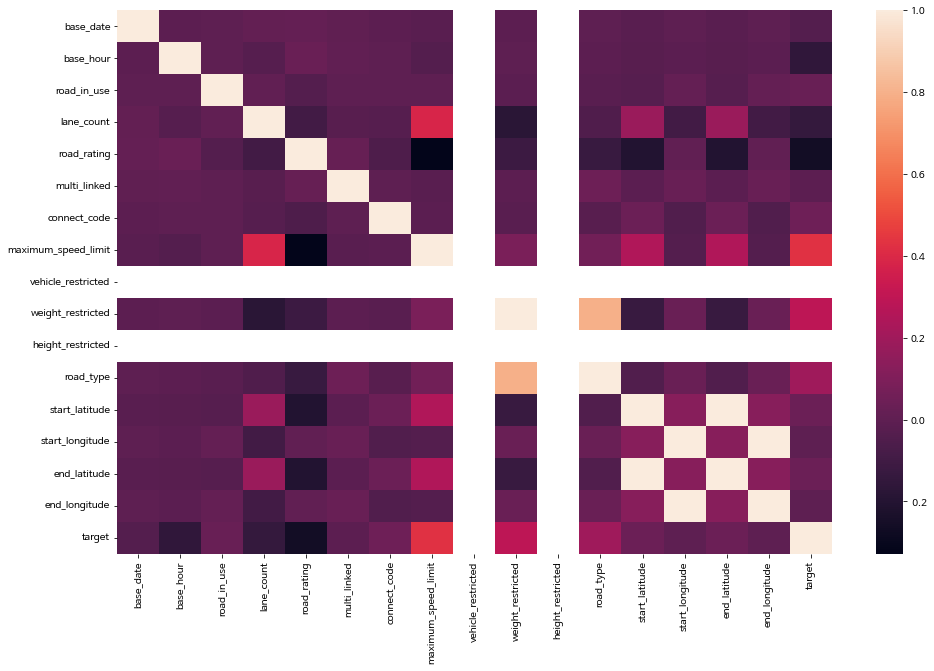

In [18]:
plt.figure(figsize = (16,10))
sns.heatmap(train.corr())
plt.show()

__Target과 상관관계가 높은 피처__
1. road_rating : 도로등급
1. maximum_speed_limit : 최고 제한속도
1. weight_restricted : 통과제한차량
1. road_type : 도로유형

In [19]:
train["weight_restricted"].unique()

array([32400.,     0., 43200., 50000.])

### 2. 날짜와 평균속도의 상관관계

__datetime 변환__

In [20]:
# int 타입
train["base_date"]

0          20220623
1          20220728
2          20211010
3          20220311
4          20211005
             ...   
4701212    20211104
4701213    20220331
4701214    20220613
4701215    20211020
4701216    20211019
Name: base_date, Length: 4701217, dtype: int64

In [21]:
# 문자열로 변환
train["base_date"] = train["base_date"].astype(str)
test["base_date"] = test["base_date"].astype(str)

In [22]:
# 날짜를 변환해서 년원일분으로 나눠주는 함수
def split_date(df, col):
    date = pd.to_datetime(df[col])
    df[col] = date
    df["year"] = date.dt.year
    df["month"] = date.dt.month
    df["day"] = date.dt.day

# train, test 데이터 둘 다 변환
split_date(train, "base_date")
split_date(test, "base_date")

In [23]:
train[["base_date","year", "month", "day"]]

,base_date,year,month,day
0,2022-06-23,2022,6,23
1,2022-07-28,2022,7,28
2,2021-10-10,2021,10,10
3,2022-03-11,2022,3,11
4,2021-10-05,2021,10,5
...,...,...,...,...
4701212,2021-11-04,2021,11,4
4701213,2022-03-31,2022,3,31
4701214,2022-06-13,2022,6,13
4701215,2021-10-20,2021,10,20


In [24]:
test[["base_date","year", "month", "day"]]

,base_date,year,month,day
0,2022-08-25,2022,8,25
1,2022-08-09,2022,8,9
2,2022-08-05,2022,8,5
3,2022-08-18,2022,8,18
4,2022-08-10,2022,8,10
...,...,...,...,...
291236,2022-08-27,2022,8,27
291237,2022-08-19,2022,8,19
291238,2022-08-05,2022,8,5
291239,2022-08-12,2022,8,12


<AxesSubplot:xlabel='month', ylabel='target'>

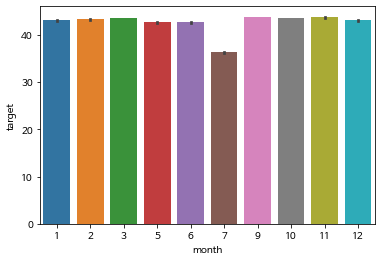

In [25]:
# 월별 평균 속도 시각화
sns.barplot(data = train, x = "month", y = "target")

- 7월은 왜 저러지?
- 7월과 7월이 아닌 달로 나눠서 1,0으로 나눠볼 수도 있을 것 같다.

<AxesSubplot:xlabel='year', ylabel='target'>

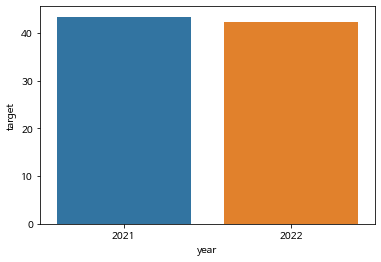

In [26]:
# 연도별 평균속도 변화
# 거의 무의미한 결과라서 무시
sns.barplot(data = train, x = "year", y = "target")

<AxesSubplot:xlabel='base_date', ylabel='target'>

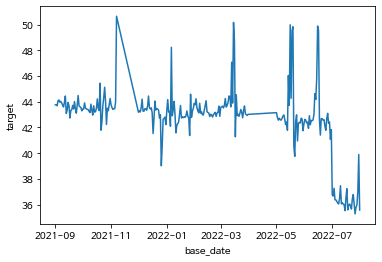

In [27]:
# 일별 평균속도

a = train.groupby(["base_date"])[["target"]].mean()
sns.lineplot(data = a, x = a.index, y = "target")

<AxesSubplot:xlabel='day', ylabel='target'>

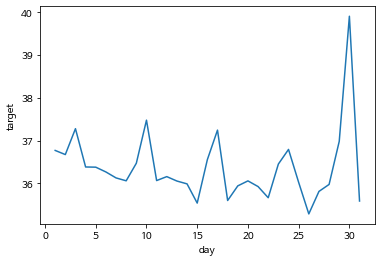

In [28]:
a = train[train["month"] == 7].groupby(["day"])[["target"]].mean()
sns.lineplot(data = a, x = a.index, y = "target")

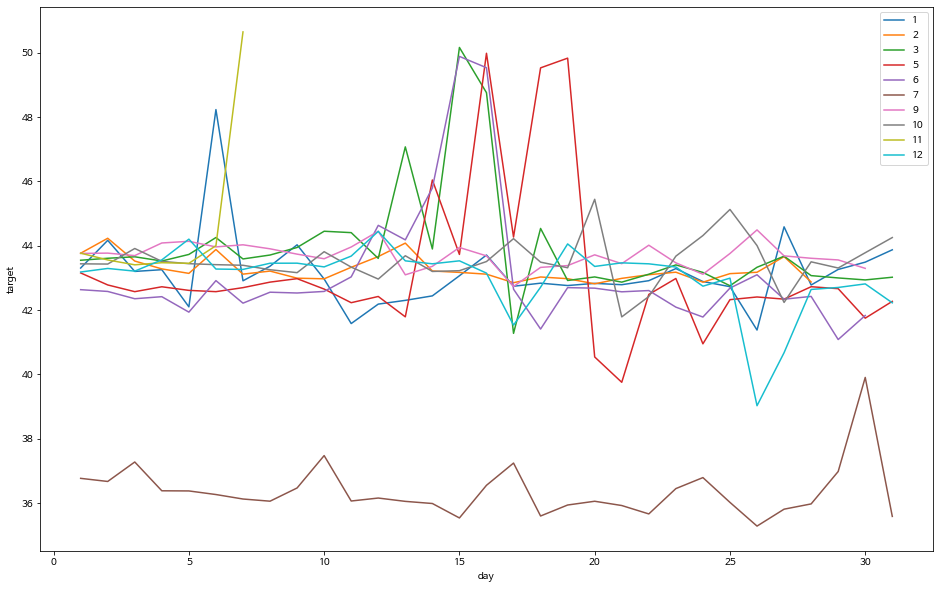

In [29]:
# 월별 일별 평균속도
plt.figure(figsize=(16,10))
for i in range(1,13):
    a = train[train["month"] == i].groupby(["day"])[["target"]].mean()
    sns.lineplot(data = a, x = a.index, y = "target", label = i)

plt.legend()
plt.show()

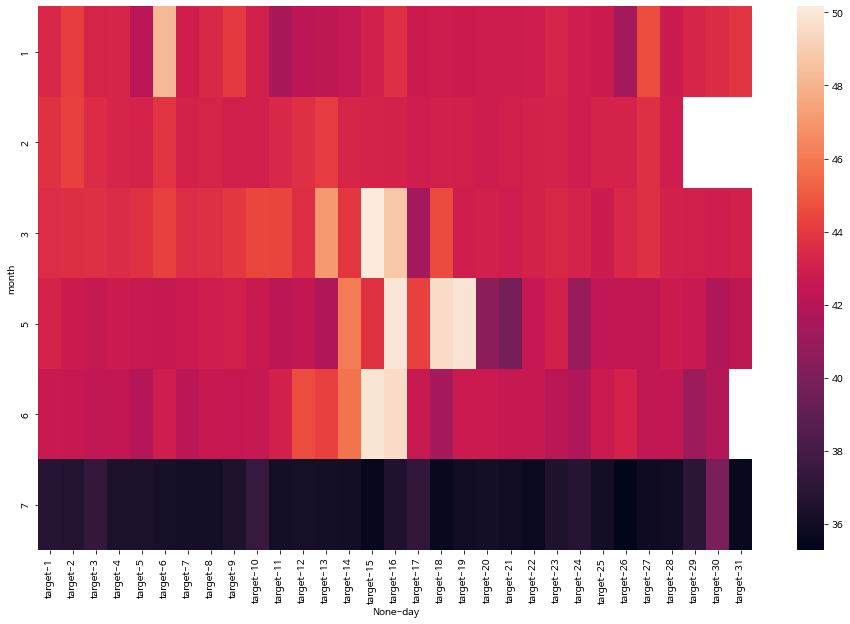

In [30]:
plt.figure(figsize=(16,10))
a = train[train["year"]==2022].groupby(["month", "day"])[["target"]].mean().unstack()
sns.heatmap(a)
plt.show()

__요일과 평균속도의 관계__

In [31]:
# 요일과 평균속도 
# seaborn에서 한글이 깨져서 데이터 프레임 대체 
# 7개 정도 비교하는데는 문제 없어보임
train.groupby(["day_of_week"])[["target"]].mean()

,target
day_of_week,
금,42.450328
목,42.768345
수,42.770372
월,42.761365
일,43.179300
토,42.894117
화,42.699198


In [32]:
from datetime import datetime, date

# 요일을 숫자로 변환
def weekday(d):
    return d.weekday()

# train test 둘다 요일 숫자로 변환
train["day_of_week"] = train["base_date"].apply(weekday)
test["day_of_week"] = test["base_date"].apply(weekday)

In [33]:
# 요일과 도착지점의 상관관계가 있을 수 있지 않을까?
# 사실 히트맵을 그리려고 했는데 한글설정을 실패해서 남겨놓습니다....
temp = train.groupby(["end_node_name","day_of_week"])[["target"]].mean().unstack()
temp

target                                              \
day_of_week            0          1          2          3          4   
end_node_name                                                          
BYC            24.907368  24.868003  25.653425  24.567850  24.561404   
CU서귀호근로점       32.295455  31.016393  32.186047  31.849624  31.303571   
KAL사거리         26.355422  26.151551  26.366667  26.039766  25.646226   
가는질            52.749258  52.684466  52.489146  52.523148  52.767507   
가동             28.602683  28.803951  28.507952  28.573469  29.074126   
...                  ...        ...        ...        ...        ...   
회수사거리          39.660448  39.252475  39.122222  39.003704  39.231325   
회수입구           41.622381  41.514038  41.633278  41.542010  41.342306   
회천교차로          59.749415  59.510588  59.593750  60.011696  59.566210   
효례교            48.746163  48.952719  48.819235  49.168816  48.312357   
흘천5교           25.541814  25.260664  25.236659  25.704094  25.287671   

                                     
day_of_week            5          6  
end_node_name                        
BYC            24.575323  25.978022  
CU서귀호근로점       32.755102  34.000000  
KAL사거리         26.934602  27.311765  
가는질            53.148499  53.395570  
가동             28.294666  28.496518  
...                  ...        ...  
회수사거리          39.221542  39.545455  
회수입구           41.510595  41.685656  
회천교차로          59.547756  59.422503  
효례교            48.800000  48.898601  
흘천5교           25.277970  26.277011  

[487 rows x 7 columns]

In [34]:
# 날짜를 받아서 주말 평일을 판단하는 함수
# 평일이면 0 주말이면 1 반환
# 금,토,일을 주말로 본다
def is_weekend(d):
    if d.weekday() > 4:
        wd = 0
    else:
        wd = 1
    return wd

# 사실 요일별 차이가 없어서 무의미해보임
train["is_weekend"] = train["base_date"].apply(is_weekend)
test["is_weekend"] = test["base_date"].apply(is_weekend)

<AxesSubplot:xlabel='is_weekend', ylabel='target'>

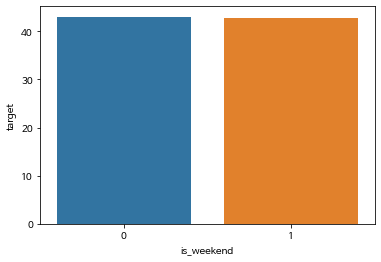

In [35]:
# 주말과 평일 시각화
a = train.groupby(["is_weekend"])[["target"]].mean()
sns.barplot(data = a, x = a.index, y = "target")

<AxesSubplot:xlabel='None-base_hour', ylabel='is_weekend'>

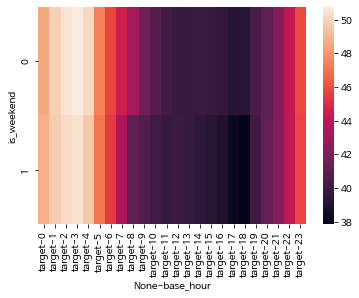

In [36]:
# 주말과 평일 시각화
a = train.groupby(["is_weekend","base_hour"])[["target"]].mean()
sns.heatmap(a.unstack())

> 평일 주말과 시간은 상관이 없음

__시간과 평균속도의 관계__

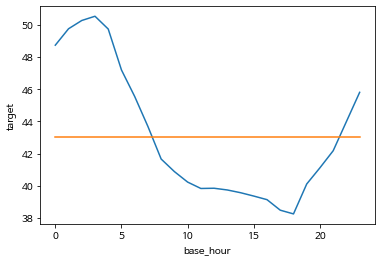

In [37]:
# 하루 중 가장 정체 되는 시간
# 빨간 선은 타겟의 중앙값
# 극단값이 많이 존재하는 데이터 이므로 평규보다는 중앙값이 더 좋은 지표로 보임
a = train.groupby(["base_hour"])[["target"]].mean()
sns.lineplot(data = a, x = a.index, y = "target")
sns.lineplot(data = a, x = a.index, y = train["target"].median())
plt.show()

In [38]:
# 평균 속도보다 느리게 달리는 시간대 
a[a["target"]<=train["target"].median()]

,target
base_hour,
8,41.656292
9,40.875939
10,40.222232
11,39.824593
12,39.838538
13,39.731471
14,39.561121
15,39.351700
16,39.127929


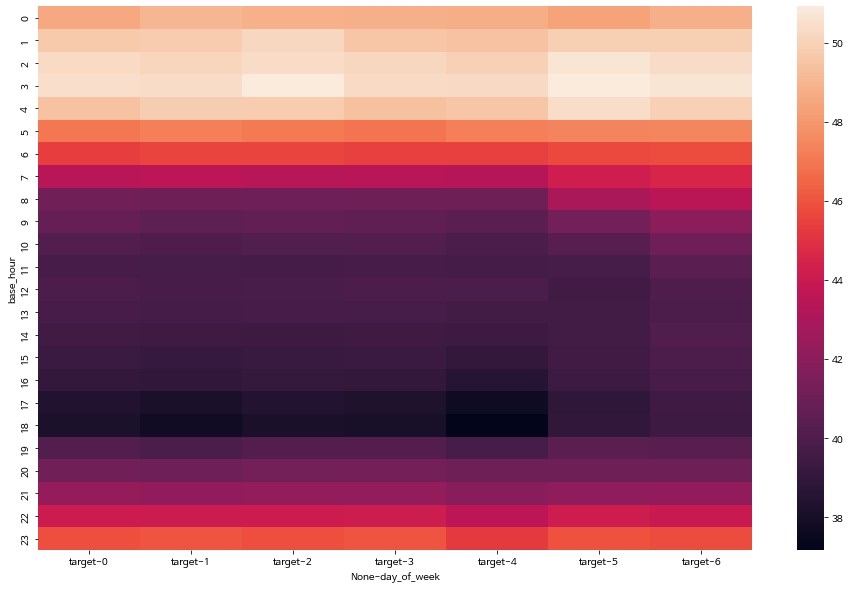

In [39]:
# 평균 속도에 대한 요일과 시간의 관계
a = train.groupby(["base_hour", "day_of_week"])[["target"]].mean()
a = a.unstack()

plt.figure(figsize=(16,10))
sns.heatmap(a)
plt.show()

- 전체 평균을 기준으로 봤을때 8시 부터 21시까지는 모두 정체 시간대로 볼 수 있다. 
- 하지만 이는 새벽시간대가 특히 교통량이 적어서 평균 속도가 왜곡 된것으로 볼 수 있다. 
- 그러므로 8~21시 구간의 평균을 기준으로 잡고 다시 확인해보자

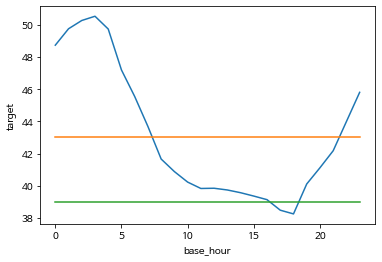

In [40]:
# 빨간 선은 모든 시간대의 평균속도의 중앙값
# 초록 선은 주요 주행시간 기준 평균 속도 중앙값
a = train.groupby(["base_hour"])[["target"]].mean()
sns.lineplot(data = a, x = a.index, y = "target")
sns.lineplot(data = a, x = a.index, y = train["target"].median())
sns.lineplot(data = a, x = a.index, y = train[(train["base_hour"]>=8) & (train["base_hour"]<=21)]["target"].median())
plt.show()

In [41]:
# 초록선 밑에 값
a[a["target"]<=train[(train["base_hour"]>=8) & (train["base_hour"]<=21)]["target"].median()]

,target
base_hour,
17,38.473363
18,38.241258


- 위 그래프로 볼때, 3개의 구간으로 라벨링 할 수 있을것으로 보임
- 0\~5시 까지는 3
- 6\~7/22\~23시 까지는 2
- 8\~17/17\~21시 까지는 1
- 17~18시는 0

In [42]:
# 시간 범주화
def time_category(x):
    if (0<=x<=5):
        y = 3
    if (6<=x<=7)or(22<=x<=23):
        y = 2
    if (8<=x<=16)or(19<=x<=21):
        y = 1
    if (17<=x<=18):
        y = 0    
    return y

train["time_category"] = train["base_hour"].apply(time_category)
test["time_category"] = test["base_hour"].apply(time_category)

>집단간의 차이를 통계적 차이를 T-test같은 방법으로 추정해 볼 수 있을듯 하나 시간이 없어서 생략

### 3. 출발지 도착지와 평균속도

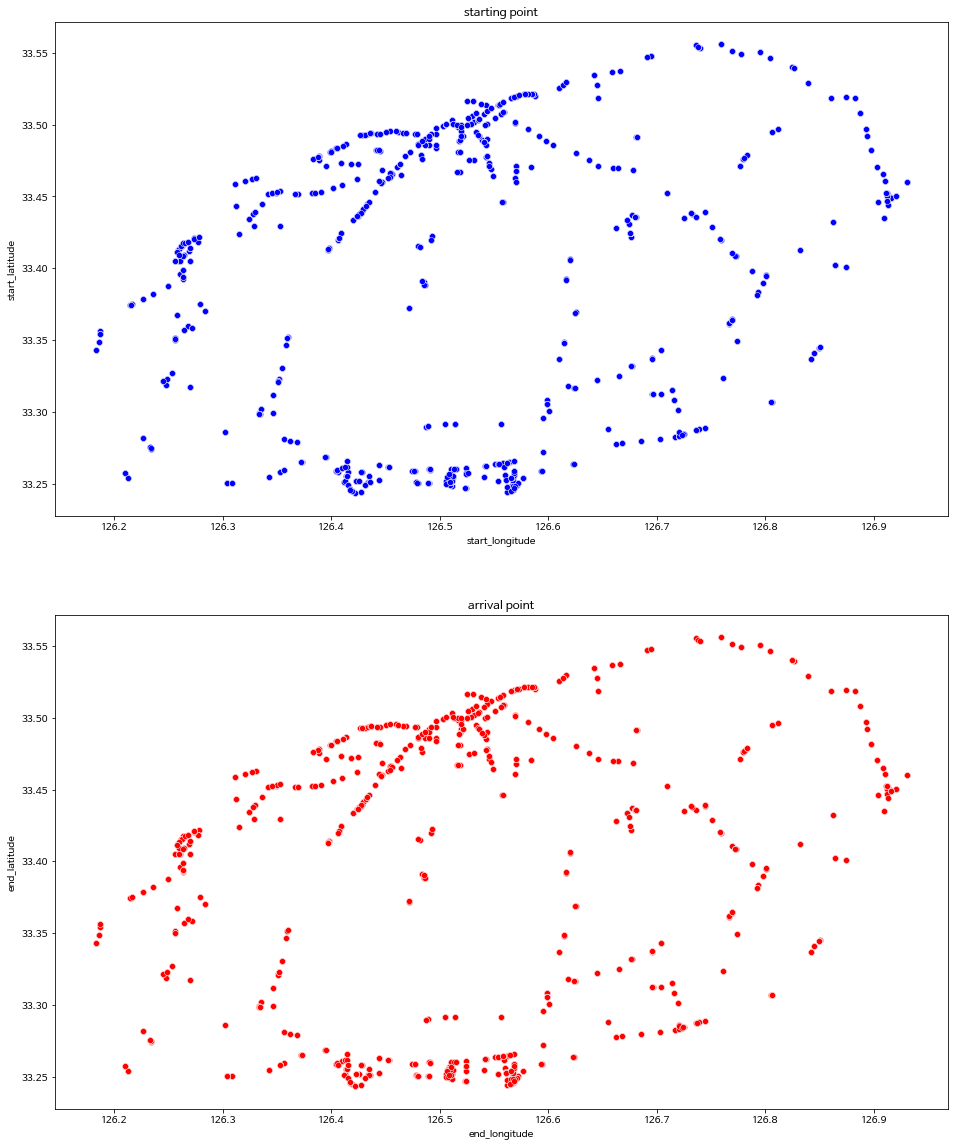

In [43]:
# 출발 
plt.figure(figsize = (16,20))
plt.subplot(211)
plt.title("starting point")
sns.scatterplot(data = train, y = "start_latitude", x = "start_longitude", color = "blue")

plt.subplot(212)
plt.title("arrival point")
sns.scatterplot(data = train, y = "end_latitude", x = "end_longitude", color = "red")

plt.show()

__도로 등급 분석__

In [44]:
# 도로 등급별 평균속도
# 원핫 인코딩 필요
train.groupby(["road_rating"])["target"].mean()

road_rating
103    46.388468
106    48.021548
107    34.701408
Name: target, dtype: float64

__최고 제한 속도 분석__

In [45]:
train["maximum_speed_limit"]

0          60.0
1          60.0
2          80.0
3          50.0
4          80.0
           ... 
4701212    50.0
4701213    80.0
4701214    60.0
4701215    80.0
4701216    60.0
Name: maximum_speed_limit, Length: 4701217, dtype: float64

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='Count'>

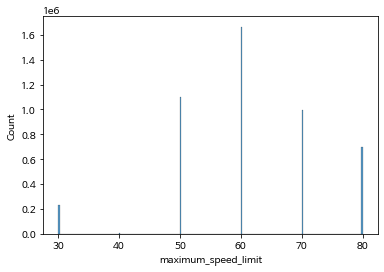

In [46]:
# 최고속도 분포
sns.histplot(data = train, x = "maximum_speed_limit")

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='target'>

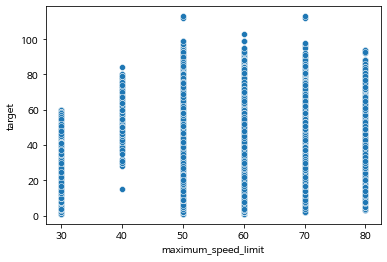

In [47]:
# 어느정도 상관 관계가 있음
# 50km/h 이상 구간에서는 거의 모든 속도를 다 볼 수 있지만 그 이하 구간에서는 최고 속력을 내는 경우가 없음
# 의외로 80km/h 도로에서 최고속도를 못내는 경우가 많음
sns.scatterplot(data = train, x= "maximum_speed_limit", y = "target")

__통과제한 차량 분석__

In [48]:
train["weight_restricted"].unique()

array([32400.,     0., 43200., 50000.])

<AxesSubplot:xlabel='weight_restricted', ylabel='target'>

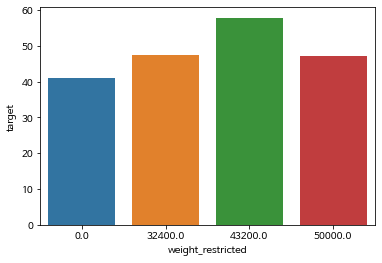

In [49]:
# 통과제한 차량별 평균 속도
a = train.groupby(["weight_restricted"])[["target"]].mean()
sns.barplot(data = a, x = a.index, y="target")

# 원핫인코딩 필요

__차로수 분석__

In [50]:
train.groupby(["lane_count"])["target"].mean()

lane_count
1    43.570562
2    44.915713
3    34.917783
Name: target, dtype: float64

> lane_count를 순서를 정렬하자

In [51]:
def lane_val(x):
    if x == 3:
        return 0
    if x == 1:
        return 1
    if x == 2:
        return 2
        
train["lane_val"] = train["lane_count"].apply(lane_val)
test["lane_val"] = test["lane_count"].apply(lane_val)

__도로 유형 분석__

In [52]:
train["road_type"]

0          3
1          0
2          0
3          0
4          0
          ..
4701212    0
4701213    3
4701214    0
4701215    0
4701216    0
Name: road_type, Length: 4701217, dtype: int64

<AxesSubplot:xlabel='road_type', ylabel='target'>

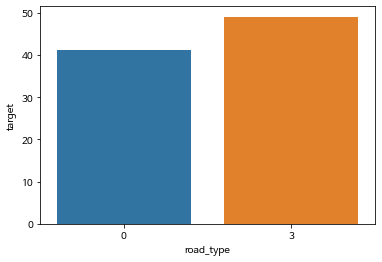

In [53]:
# 도로 유형별 통계
# 원핫 인코딩 필요
a = train.groupby(["road_type"])[["target"]].mean()
sns.barplot(data = a, x = a.index, y = "target")

__주행거리__

In [54]:
train["distance"] = ((train["end_latitude"] - train["start_latitude"])**2 + (train["end_longitude"] - train["start_longitude"])**2 )**(1/2)
train["distance"]

0          0.000277
1          0.004987
2          0.006516
3          0.001104
4          0.003630
             ...   
4701212    0.004533
4701213    0.000522
4701214    0.003084
4701215    0.002063
4701216    0.001465
Name: distance, Length: 4701217, dtype: float64

In [55]:
test["distance"] = ((test["end_latitude"] - test["start_latitude"])**2 + (test["end_longitude"] - test["start_longitude"])**2 )**(1/2)
test["distance"]

0         0.002873
1         0.011171
2         0.001837
3         0.002440
4         0.012863
            ...   
291236    0.003197
291237    0.004778
291238    0.003880
291239    0.000933
291240    0.000857
Name: distance, Length: 291241, dtype: float64

<AxesSubplot:xlabel='distance', ylabel='Density'>

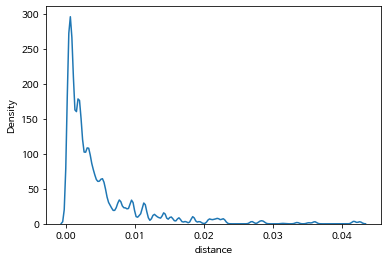

In [56]:
# 거리 분포 확인
sns.kdeplot(train["distance"])

<AxesSubplot:xlabel='distance', ylabel='target'>

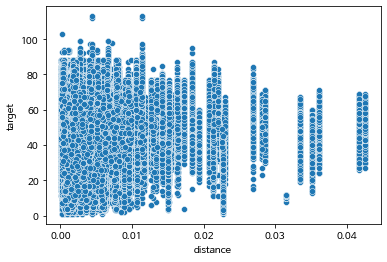

In [57]:
sns.scatterplot(data = train, x = "distance", y = "target")

In [58]:
# # 거리 정규화
# scale = train["distance"].max() - train["distance"].min()
# train["distance"] = (train["distance"]-train["distance"].min())/scale

In [59]:
# # 거리 정규화
train["distance_std"] = np.log1p(train["distance"] * 100000)
test["distance_std"] = np.log1p(test["distance"] * 100000)

<AxesSubplot:xlabel='distance_std', ylabel='Density'>

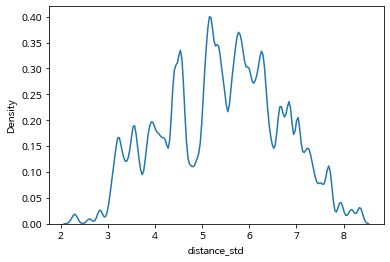

In [60]:
sns.kdeplot(train["distance_std"])

<AxesSubplot:xlabel='distance', ylabel='Density'>

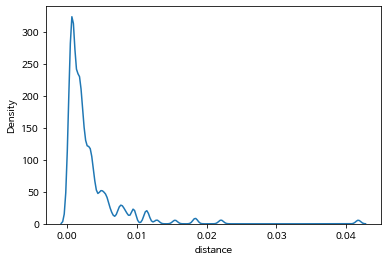

In [61]:
sns.kdeplot(test["distance"])

__target 분포 확인__

<AxesSubplot:xlabel='target', ylabel='Density'>

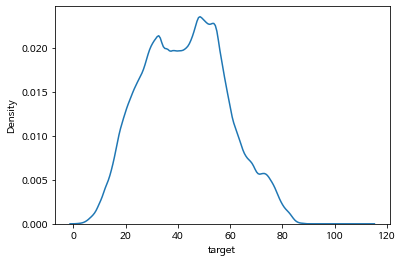

In [62]:
sns.kdeplot(train["target"])

> 분포에 문제 없음

## 4. 예측

In [63]:
# 요일 시작지점과 도착지점의 회전제한 유무 수치형으로 변환
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [64]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [65]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {"model":rdforest, "name" : "RandomForest"}]

# 점수 평가
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model["name"]

        # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                            y,
                                                            random_state = random_state,
                                                            test_size = 0.2)

        # 모델 학습
        model["model"].fit(X_train, y_train)

        # 예측
        y_pred = model["model"].predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = mean_absolute_error(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
    return score_df

__1차 시도__  
MAE  
GradientBoosting	6.626976  
XGBoost	6.613849  
LightGBM	4.942239  
RandomForest	3.800149  

In [66]:
# # 1차 시도
# y_train = train['target'] 

# X_train = train[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]

# Test = test[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted"])

# get_scores(models, X_train, y_train)

__2차 시도__

In [67]:
# # 2차 시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "time_category","road_in_use","maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]

# Test = test[["year","month","day", "time_category","road_in_use",  "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]

# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["weight_restricted"])
# Test = pd.get_dummies(Test, columns = ["weight_restricted"])
# X_train = X_train.values
# get_scores(models, X_train, y_train)

__3차 시도__

MAE  
XGBoost	7.168604  
GradientBoosting	7.154547  
LightGBM	5.639127  
RandomForest	4.874068  

In [68]:
# #3차시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "road_in_use","maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]

# Test = test[["year","month","day", "road_in_use",  "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted"]]
# X_train = X_train.values
# print(X_train.shape)
# print(y_train.shape)

# get_scores(models, X_train, y_train)

__4차 시도__

MAE  
XGBoost	7.028998  
GradientBoosting	7.018870  
LightGBM	5.533011  
RandomForest	4.874066  

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 32 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     object        
 1   base_date              datetime64[ns]
 2   day_of_week            int64         
 3   base_hour              int64         
 4   road_in_use            int64         
 5   lane_count             int64         
 6   road_rating            int64         
 7   road_name              object        
 8   multi_linked           int64         
 9   connect_code           int64         
 10  maximum_speed_limit    float64       
 11  vehicle_restricted     float64       
 12  weight_restricted      float64       
 13  height_restricted      float64       
 14  road_type              int64         
 15  start_node_name        object        
 16  start_latitude         float64       
 17  start_longitude        float64       
 18  start_turn_restricted 

In [70]:
# #4차시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "road_in_use","maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted", "distance_std"]]

# Test = test[["year","month","day", "road_in_use",  "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["weight_restricted"])
# Test = pd.get_dummies(Test, columns = ["weight_restricted"])
# X_train = X_train.values
# get_scores(models, X_train, y_train)

__5차 시도__

MAE  
XGBoost	7.028998  
GradientBoosting	7.018870  
LightGBM	5.533011  
RandomForest	4.874217  

In [71]:
# #5차시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted", "distance_std"]]

# Test = test[["year","month","day", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["weight_restricted"])
# Test = pd.get_dummies(Test, columns = ["weight_restricted"])
# X_train = X_train.values
# get_scores(models, X_train, y_train)

__6차 시도__  
MAE  
XGBoost	8.700481  
GradientBoosting	8.700422  
LightGBM	6.918960  
RandomForest	5.697142  

In [72]:
# #6차시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "maximum_speed_limit", "weight_restricted", "distance_std"]]

# Test = test[["year","month","day", "maximum_speed_limit", "weight_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["weight_restricted"])
# Test = pd.get_dummies(Test, columns = ["weight_restricted"])
# X_train = X_train.values
# get_scores(models, X_train, y_train)

__7차 시도__  
MAE   
XGBoost	6.486970  
GradientBoosting	6.463965  
LightGBM	4.845100  
RandomForest	3.800750  

In [73]:
# 7차 시도
# y_train = train['target'] 

# X_train = train[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "maximum_speed_limit", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted"])

# get_scores(models, X_train, y_train)

__8차 시도__  
lightgbm 파라미터 수정 :  
lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)  
> 이제부터 lightgbm만 사용해서 실험


MAE
LightGBM	3.94981

In [74]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df

In [75]:
# # 8차 시도
# y_train = train['target'] 

# X_train = train[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","month","day","day_of_week", "time_category","road_in_use", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted"])

# get_scores(models, X_train, y_train)

__9차시도__
1. month_value 피처 추가  
    - 7월만 유독 다른 경향을 보여줘서 7월과 7월이 아닌 달로 분리해서 0, 1로 원핫인코딩 함 

2. day_of_week 피처 삭제

In [76]:
def m_value(x):
    if x == 7:
        return 1
    else :
        return 0

train["month_value"] = train["month"].apply(m_value)
test["month_value"] = test["month"].apply(m_value)

In [77]:
# # 9차 시도
# y_train = train['target'] 

# X_train = train[["year","month","day", "month_value","time_category", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","month","day","month_value", "time_category", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted"])

# get_scores(models, X_train, y_train)

__10차 시도__
1. month 삭제

In [78]:
# # 10차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month_value","time_category", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month_value", "time_category", "road_rating", "weight_restricted","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted"])

# get_scores(models, X_train, y_train)

__11차 시도__
1. multi_linked, connect_code 분석



MAE  
LightGBM	3.951884

In [79]:
# print(train["multi_linked"].unique())
# print(train["connect_code"].unique())

In [80]:
# a = train.groupby(["multi_linked","connect_code"])["target"].mean()
# a.unstack()

In [81]:
train["multi_connect_code"] = train['multi_linked'] + train['connect_code']
test["multi_connect_code"] = test['multi_linked'] + test['connect_code']

In [82]:
# # 11차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","time_category", "road_rating", "weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month", "time_category", "road_rating", "weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code"])

# get_scores(models, X_train, y_train)

__12차 시도__
1. time_category 삭제

MAE  
LightGBM	3.694648

In [83]:
# # 12차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month", "base_hour","road_rating", "weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month", "base_hour","road_rating", "weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code"])

# get_scores(models, X_train, y_train)

__13차 시도__
1. maximum_speed_limit 피처 추가

In [84]:
# # 13차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month", "base_hour","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month", "base_hour","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code","start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit"])

# get_scores(models, X_train, y_train)

__14차 시도__
1. 시작지점 위경도 삭제
1. 요일 추가

In [85]:
# # 14차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month", "day_of_week","base_hour","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])

# get_scores(models, X_train, y_train)

__15차 시도__
1. 시작지점 다시 추가

In [86]:
# # 15차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]

# Test = test[["year","day","month", "day_of_week","base_hour","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])

# get_scores(models, X_train, y_train)

__16차 시도__
1. time_category 추가 : 결과 향상
1. distance_std 추가 : 거리 정규화

In [87]:
# # 16차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","maximum_speed_limit","day_of_week"])

# get_scores(models, X_train, y_train)

__17차 시도__
1. maximum_speed_limit : 원핫 인코딩 제거

In [88]:
# # 17차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])

# get_scores(models, X_train, y_train)

__18차 시도__
n_estimators == 5000

In [89]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 5000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df


# # 18차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]
# print(X_train.shape)
# print(y_train.shape)

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])
# Test = pd.get_dummies(test, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])

# get_scores(models, X_train, y_train)

__19차 시도__


In [90]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df


# # 19차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "maximum_speed_limit","weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])
# Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] != Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [91]:
# Test = test[["year","day", "month","day_of_week", "base_hour","time_category","road_rating", "maximum_speed_limit", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]
# Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","multi_connect_code","day_of_week"])

# print(X_train.shape)
# print(Test.shape)

In [92]:
# X_train.columns

In [93]:
# Test.columns

In [94]:
# Test["multi_connect_code_0"]

> multi_connect_code_0가 test에서는 하나밖에 없음


__20차 시도__  
multi_connect_code 제거

LightGBM 3.107166897599904

제출 점수 : 3.36165

In [95]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df


# # 20차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating",  "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "weight_restricted","multi_connect_code", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

__21차 시도__  
multi_connect_code 삭제

In [96]:
# print(train["road_rating"].unique())
# print(test["road_rating"].unique())

In [97]:
# print(train["weight_restricted"].unique())
# print(test["weight_restricted"].unique())

In [98]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df


# # 21차 시도
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

__22차 시도__  
1. lane_count를 변형한 lane_val 피처 추가
1. year+month 피처 추가
1. day_of_week + base_hour 피처 추가
1. road_type 추가  
> 각각의 피처를 하나씩 넣어보면서 실험 해보자  
n_estimator= 1000으로 변경

In [99]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df

In [100]:
# # 22차 시도- 
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week", "base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [101]:
# # 22차 시도-lane_val추가
# y_train = train['target'] 

# X_train = train[["year","day", "month","day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year","day","month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [102]:
def month_c(x):
    if (x != "10")&(x != "11")&(x != "12"):
        return "0"+x
    else:
        return x

In [103]:
# year+month 합치기
train["year_str"] = train["year"].astype(str)
train["month_str"] = train["month"].astype(str)
train["month_str"] = train["month_str"].apply(month_c)
train["year_month"] = train["year_str"] + train["month_str"]
train["year_month"] = train["year_month"].astype(int)

test["year_str"] = test["year"].astype(str)
test["month_str"] = test["month"].astype(str)
test["month_str"] = test["month_str"].apply(month_c)
test["year_month"] = test["year_str"] + test["month_str"]
test["year_month"] = test["year_month"].astype(int)

In [104]:
# # 22차 시도-lane_val추가 + (year+_month)추가, 원래 year, month 삭제
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [105]:
train["day_of_week"]=train["day_of_week"].astype(int)
test["day_of_week"]=test["day_of_week"].astype(int)

In [106]:
# day+day_of_week = day_week
train["base_hour_str"] = train["base_hour"].astype(str)
train["day_of_week_str"] = train["day_of_week"].astype(str)
train["hour_week"] = train["base_hour_str"] + train["day_of_week_str"]
train["hour_week"] = train["hour_week"].astype(int)

test["base_hour_str"] = test["base_hour"].astype(str)
test["day_of_week_str"] = test["day_of_week"].astype(str)
test["hour_week"] = test["base_hour_str"] + test["day_of_week_str"]
test["hour_week"] = test["hour_week"].astype(int)

In [107]:
# # 22차 시도-lane_val추가 
# #(year+_month)추가, 원래 year, month 삭제 
# # hour_week 추가, 원래 base_hour, week 삭제
# y_train = train['target'] 

# X_train = train[["year_month","day","hour_week", "lane_val","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day","hour_week","lane_val","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [108]:
# # 22차 시도-lane_val추가 
# #(year+_month)추가, 원래 year, month 삭제 
# # hour_week 추가, 원래 base_hour, week 삭제 -> 결과 별로 안 좋음, 다시 복구
# # road_type 추가
# y_train = train['target'] 

# X_train = train[["road_type","year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["road_type","year_month","day", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [109]:
# # 22차 시도
# # lane_val추가 
# #(year+_month)추가, 원래 year, month 삭제 
# # hour_week 추가, 원래 base_hour, week 삭제 -> 결과 별로 안 좋음, 다시 복구
# # road_type 추가 -> 별로 효과 없음, 제거
# # time_category 제거
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day", "day_of_week","lane_val","base_hour","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

22차 결론
>"year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"

In [110]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df

# # 22차 시도-lane_val추가 + (year+_month)추가, 원래 year, month 삭제
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

__22차 시도 제출결과__
> 테스트 제출 결과 3.27~~  달성

In [111]:
# # 22차 시도-lane_val추가 + (year+_month)추가, 원래 year, month 삭제
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
# lightgbm.fit(X_train, y_train)
# pred = lightgbm.predict(Test)
# pred

In [112]:
# # 제출 파일 생성 함수
# def save_submit(X, y, test,trynum):
#     lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
#     lightgbm.fit(X, y)
#     pred = lightgbm.predict(Test)

#     sample_submission = pd.read_csv('/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/98.kaggle_study/02.dacon_jejutrafficAI/data/sample_submission.csv')
#     sample_submission['target'] = pred
#     sample_submission.to_csv(f"/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/98.kaggle_study/02.dacon_jejutrafficAI/submit_{trynum}.csv", index = False)

__23차 시도__  
> 딥러닝을 활용한 예측 시도

In [113]:
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]


In [114]:
# X_train = train
# y_train = train["target"]

In [115]:
# from keras import models
# from keras import layers

# def build_model(df): #동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다.
#     model = models.Sequential()
#     model.add(layers.Dense(32, activation='relu',
#                            input_shape=(df.shape[1],)))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(1))
#     model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#     return model

In [116]:
# k = 4

# num_val_samples = len(X_train) // k
# num_epochs = 10
# all_scores = []
# for i in range(k):
#     print('처리중인 폴드 #', i)
#     val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
#     val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

#     partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
#         [X_train[:i * num_val_samples],
#          X_train[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [y_train[:i * num_val_samples],
#          y_train[(i + 1) * num_val_samples:]],
#         axis=0)

#     model = build_model(X_train)  # 케라스 모델 구성(컴파일 포함)
#     model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
#             epochs=num_epochs, batch_size=1, verbose=1)
#     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
#     all_scores.append(val_mae)

> 딥러닝을 시도했는데 시간이 너무 오래 걸려서 효율이 좋지 않음

__24차 시도__  
> 극단치를 제거해보자

In [117]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df

# # 22차 시도-lane_val추가 + (year+_month)추가, 원래 year, month 삭제
# y_train = train['target'] 

# X_train = train[["year_month","day", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month","day", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

In [118]:
# info

In [119]:
# # lane_val 극단치 탐색
# sns.boxplot(data = train, x = "lane_val", y = "target")

In [120]:
def outlier(df):
    q1 = df["target"].quantile(.25)
    q3 = df["target"].quantile(.75)
    lower = q1 - ((q3 - q1) * 1.2)
    upper = q3 + ((q3 - q1) * 1.2)

    df = df[(df["target"]>lower) & (df["target"]<upper)]
    return df

In [121]:
# a1 = train[train["lane_val"] == 0]
# a2 = train[train["lane_val"] == 1]
# a3 = train[train["lane_val"] == 2]

# for i in [a1, a2, a3]:
#     i = outlier(i)

# train_1 = pd.concat([a1,a2,a3], ignore_index=True)
# train_1

In [122]:
# train["time_category"].unique()

In [123]:
# a1 = train[train["time_category"] == 0]
# a2 = train[train["time_category"] == 1]
# a3 = train[train["time_category"] == 2]
# a4 = train[train["time_category"] == 3]

# for i in [a1, a2, a3,a4]:
#     i = outlier(i)

# train_2 = pd.concat([a1,a2,a3, a4], ignore_index=True)
# train_2

In [124]:
# train["weight_restricted"].unique()

In [125]:
# sns.boxplot(data = train, x = "weight_restricted", y = "target")

In [126]:
# a1 = train[train["weight_restricted"] == 0]
# a2 = train[train["weight_restricted"] == 32400]
# a3 = train[train["weight_restricted"] == 43200]
# a4 = train[train["weight_restricted"] == 50000]

# for i in [a1, a2, a3,a4]:
#     i = outlier(i)

# train_2 = pd.concat([a1,a2,a3, a4], ignore_index=True)
# train_2

__결론__
>이상치 없음...  
"day" 피처 삭제후 다시 시도

In [127]:
# random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
# lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}]

# # 점수 평가
# def get_scores(models, train, y):
#     df = {}

#     for model in models:
#         # 모델 이름 획득
#         model_name = model["name"]

#         # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
#         X_train, X_test, y_train, y_test = train_test_split(train,
#                                                             y,
#                                                             random_state = random_state,
#                                                             test_size = 0.2)

#         # 모델 학습
#         model["model"].fit(X_train, y_train)

#         # 예측
#         y_pred = model["model"].predict(X_test)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = mean_absolute_error(y_test, y_pred)
#         print(model_name,df[model_name])

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
#     return score_df

# # 22차 시도-lane_val추가 + (year+_month)추가, 원래 year, month 삭제
# y_train = train['target'] 

# X_train = train[["year_month", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# # 원핫인코딩
# # X_train = pd.get_dummies(X_train, columns = ["road_rating","weight_restricted","day_of_week"])
# # Test = pd.get_dummies(Test, columns = ["road_rating","weight_restricted","day_of_week"])

# print(X_train.shape)
# print(y_train.shape)
# print(Test.shape)

# if X_train.shape[1] == Test.shape[1]:
#     get_scores(models, X_train, y_train)

__25차 시도__
> 최근 경향성이 변하였다고 한점을 근거로
7월 데이터를 2번 더 추가

In [128]:
# train[train["month"] == 7]

In [129]:
# train_1 = pd.concat([train, train[train["month"] == 7], train[train["month"] == 7]], ignore_index=True)
# train_1

> 2번 추가하자 결과가 오히려 나쁘게 나옴

__26차 시도__
> 7월만 두번 넣는것은 실패했으므로 6,7월을 넣는다.  
3.16!!!! 성공 아주 효과는 성공적이었다.

In [130]:
# train_1 = pd.concat([train, train[train["month"] == 6], train[train["month"] == 7]], ignore_index=True)
# train_1

In [131]:
# y_train = train_1['target'] 

# X_train = train_1[["year_month", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]

# Test = test[["year_month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std"]]
# save_submit(X_train, y_train, Test, 26)

__27차 시도__
1. 도로명, 시작지점명, 도착지점명 라벨인코딩해서 추가하기

In [132]:
# 제출 파일 생성 함수
def save_submit(X, y, test,trynum):
    lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 10000,random_state=random_state)
    lightgbm.fit(X, y)
    pred = lightgbm.predict(Test)

    sample_submission = pd.read_csv('/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/98.kaggle_study/02.dacon_jejutrafficAI/data/sample_submission.csv')
    sample_submission['target'] = pred
    sample_submission.to_csv(f"/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/98.kaggle_study/02.dacon_jejutrafficAI/submit_{trynum}.csv", index = False)

In [133]:
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [134]:
# 요일 시작지점과 도착지점의 회전제한 유무 수치형으로 변환
str_col = ['road_name','start_node_name','end_node_name']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [135]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state=random_state)
lightgbm = LGBMRegressor(learning_rate = 0.05, max_depth = 10, n_estimators = 1000,random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':lightgbm, 'name':'LightGBM'}]

# 점수 평가
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model["name"]

        # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                            y,
                                                            random_state = random_state,
                                                            test_size = 0.2)

        # 모델 학습
        model["model"].fit(X_train, y_train)

        # 예측
        y_pred = model["model"].predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = mean_absolute_error(y_test, y_pred)
        print(model_name,df[model_name])

        # data frame에 저장
        score_df = pd.DataFrame(df, index = ["MAE"]).T.sort_values("MAE", ascending = False)
    return score_df

# 27차 시도-'road_name','start_node_name','end_node_name' 라벨인코딩
y_train = train['target'] 

X_train = train[["year_month", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]

Test = test[["year_month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]


print(X_train.shape)
print(y_train.shape)
print(Test.shape)

if X_train.shape[1] == Test.shape[1]:
    get_scores(models, X_train, y_train)

(4701217, 16)
(4701217,)
(291241, 16)
LightGBM 3.6045075032882132


In [136]:
# # 6월 7월 데이터 추출해서 추가
# train_1 = pd.concat([train, train[train["month"] == 6], train[train["month"] == 7]], ignore_index=True)

# y_train = train_1['target'] 

# X_train = train_1[["year_month", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]

# Test = test[["year_month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]

# save_submit(X_train, y_train, Test, 27)

> 데이콘 점수 3.15559  
효과있음

__28차 시도__
1. DBSCAN사용해서 위경도 클러스터링해서 라벨 붙이기 -> 도착지를 기준으로 라벨링 
1. 6,7월의 평균속도와 나머지 기간의 평균속도의 차이를 비교해서 나머지 기간들을 알맞은 비율만큼 조정한다. 

In [137]:
# 요일 시작지점과 도착지점의 회전제한 유무 수치형으로 변환
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [138]:
a = train[(train["month"]==6)|(train["month"]==7)]["target"].mean()
b = train[(train["month"]!=6)&(train["month"]!=7)]["target"].mean()

per = a/b
per

0.9324119743600977

In [139]:
train[(train["month"]!=6)&(train["month"]!=7)]["target"]

2          61.0
3          20.0
4          38.0
5          28.0
6          39.0
           ... 
4701211    27.0
4701212    20.0
4701213    65.0
4701215    73.0
4701216    35.0
Name: target, Length: 3936385, dtype: float64

In [140]:
train1 = train[(train["month"]!=6)&(train["month"]!=7)].copy()

In [141]:
train1["target"] = train1["target"].apply(lambda x: x*per)

In [142]:
train1["target"]

2          56.877130
3          18.648239
4          35.431655
5          26.107535
6          36.364067
             ...    
4701211    25.175123
4701212    18.648239
4701213    60.606778
4701215    68.066074
4701216    32.634419
Name: target, Length: 3936385, dtype: float64

In [143]:
train1.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target', 'year', 'month',
       'day', 'is_weekend', 'time_category', 'lane_val', 'distance',
       'distance_std', 'month_value', 'multi_connect_code', 'year_str',
       'month_str', 'year_month', 'base_hour_str', 'day_of_week_str',
       'hour_week'],
      dtype='object')

In [144]:
a = train[(train["month"]==6)|(train["month"]==7)]
a

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,distance,distance_std,month_value,multi_connect_code,year_str,month_str,year_month,base_hour_str,day_of_week_str,hour_week
0,TRAIN_0000000,2022-06-23,3,17,0,1,106,46,0,0,...,0.000277,3.357067,0,0,2022,06,202206,17,3,173
1,TRAIN_0000001,2022-07-28,3,21,0,2,103,34,0,0,...,0.004987,6.214033,1,0,2022,07,202207,21,3,213
10,TRAIN_0000010,2022-06-23,3,11,0,1,103,38,0,0,...,0.003554,5.876013,0,0,2022,06,202206,11,3,113
11,TRAIN_0000011,2022-07-24,6,2,0,1,107,45,0,0,...,0.002035,5.320521,1,0,2022,07,202207,2,6,26
16,TRAIN_0000016,2022-07-01,4,22,0,2,107,29,0,0,...,0.003571,5.880877,1,0,2022,07,202207,22,4,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701179,TRAIN_4701179,2022-06-30,3,17,0,1,106,52,0,0,...,0.000237,3.207328,0,0,2022,06,202206,17,3,173
4701181,TRAIN_4701181,2022-06-20,0,6,0,3,103,34,0,0,...,0.002082,5.343306,0,0,2022,06,202206,6,0,60
4701186,TRAIN_4701186,2022-06-05,6,0,0,1,107,5,0,0,...,0.003318,5.807411,0,0,2022,06,202206,0,6,6
4701197,TRAIN_4701197,2022-07-16,5,19,0,1,107,0,0,0,...,0.000519,3.967708,1,0,2022,07,202207,19,5,195


In [145]:
# # 6월 7월 데이터 추출해서 추가
# a = train[(train["month"]==6)|(train["month"]==7)]
# train1 = pd.concat([train1, a, a], ignore_index=True)

# y_train = train1['target'] 

# X_train = train1[["year_month", "day_of_week", "lane_val","base_hour","time_category","road_rating",  "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]

# Test = test[["year_month", "day_of_week","lane_val","base_hour","time_category","road_rating", "weight_restricted", "start_latitude", "start_longitude", "end_latitude","end_longitude","end_turn_restricted","distance_std",'road_name','start_node_name','end_node_name']]

# save_submit(X_train, y_train, Test, 28)

> 나머지 month 타겟을 줄여서 계산해서 만들어봤지만 성과 안 좋음

__29차 시도__


In [146]:
# 클러스터링 시도
# k-means clusturing을 통한 구역 분류
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def area_div(df, k):
    sc = StandardScaler()
    X = sc.fit_transform(df[["end_latitude", "end_longitude", "base_hour", "month"]])

    # 클러스터링 학습
    K = k
    kmeans = KMeans(n_clusters = K, random_state = 0)
    kmeans.fit(X)
    y_kmeans = kmeans.fit_predict(X)

    return y_kmeans

In [147]:
train["area_group"] = area_div(train, 10)

In [148]:
a = train.groupby(["area_group"])[["target"]].mean()
a.sort_values(ascending = False, by = "target")

,target
area_group,
4,48.586487
0,48.502057
3,45.881198
7,44.796302
6,44.538304
2,44.383412
9,40.206581
1,39.136696
5,38.891594


<AxesSubplot:xlabel='area_group', ylabel='target'>

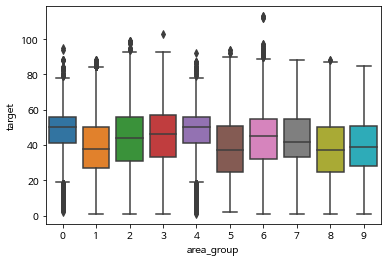

In [149]:
sns.boxplot(data = train, x = "area_group", y = "target")

In [150]:
train["end_latitude"]

0          33.427749
1          33.504811
2          33.280072
3          33.245565
4          33.462677
             ...    
4701212    33.420955
4701213    33.472525
4701214    33.444121
4701215    33.444996
4701216    33.257130
Name: end_latitude, Length: 4701217, dtype: float64

In [151]:
import folium 
from folium.plugins import HeatMap

def traffic_heatmap(df):
#     df_area_group = df.groupby(["agrea_group"])[["end_longitude","end_latitude","target"]].agg({"X": "mean", "Y" : "mean", "target" : "mean"})

    lat = df["end_latitude"].mean()
    long = df["end_longitude"].mean()

    # 지도 띄우기
    m = folium.Map([lat, long], zoom_start = 14)

    HeatMap(zip(df["end_latitude"], df["end_longitude"], df["target"]),
           min_opacity=0.1,
           max_val=5,
           radius=30,
           blur=15,
           max_zoom=5,
           color="red").add_to(m)
    
    for i in df.index:
        sub_lat = df.loc[i, "end_latitude"]
        sub_long = df.loc[i, "end_longitude"]
        folium.Circle([sub_lat, sub_long], 
                      tooltip = i,
                       radius = 20,
                      icon=folium.Icon(color='green')
                     ).add_to(m)
    return m

In [ ]:
traffic_heatmap(train)

/tmp/ipykernel_178/673114010.py:13: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(zip(df["end_latitude"], df["end_longitude"], df["target"]),


22년 10월 26일 스터디
1. feature importance 활용
1. extra tree

In [ ]:
# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=None, random_state=42)

In [ ]:
# # lightgbm = LGBMRegressor(learning_rate = 0.05,max_depth = 10, n_estimators = 1000, random_state = random_state)
# xgboost = XGBRegressor(tree_method = "gpu_hist", learning_rate = 0.05,max_depth = 10, n_estimators = 10000, random_state = random_state)
# xgboost.fit(X_train, y_train)
# pred = lightgbm.predict(test)
# pred

### 그리드 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
"""
다음과 같은 과정을 진행할 수 있는 
`my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 
함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # 1. GridSearchCV 모델로 'model'을 초기화합니다. 
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring = 'neg_mean_squared_error', \
                        cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]
    
    # 데이터 프레임을 생성하고,  
    params_score = pd.DataFrame(params)
    params_score["score"] = score
    
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬하고 값을 반환한다.
    params_score["RMSLE"] = np.sqrt(-score)
    params_score.sort_values(by="RMSLE", ascending = False, inplace = True)
    
    return params_score


In [ ]:
# LGBMRegressor 파라미터 평가
warnings.filterwarnings('ignore')
param_grid = {
    'n_estimators': [1000, 10000],
    'max_depth': [3,5,7,10],
    "learning_rate" : [0.05, 0.08, 0.1]
}

model = LGBMRegressor(random_state=random_state)
# model = LGBMRegressor( random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

In [ ]:
# XGBoost 파라미터 평가
warnings.filterwarnings('ignore')
param_grid = {
    'n_estimators': [1000, 10000],
    'max_depth': [i for i in range(3,11)],
    "learning_rate" : [0.05, 0.08, 0.1]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, x_train, y_train, param_grid, verbose=2, n_jobs=5)